In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
# We run an OLS regression for a certain timewindow (n)
# The independent variables are the days (ex. Day 0, Day 1) > X
# The dependent variable is the Close Price

# For each day we need a prediciton based on this regression over the past n days

In [ ]:
df = yf.download('AAPL', start='2020-01-01')

In [3]:
window = 25 # regression over the first 25 rows

In [4]:
test_df = df[:window]

In [ ]:
# Creating the Lieanr Regression

In [5]:
y_ = test_df.Close

In [ ]:
# We want the the date to turn into an integer (ex. 2020-01-01 > Day 0)

In [6]:
X_ = pd.Series(range(len(test_df.index))).values

In [7]:
model_ = sm.OLS(y_, sm.add_constant(X_)).fit()

In [8]:
model_.params
# 75.714038 is the intercept
# x1 is the slope

const    75.714038
x1        0.210839
dtype: float64

In [ ]:
# We need a prediction for the last row (24)

In [9]:
intercept = model_.params['const']
slope = model_.params['x1']

In [10]:
intercept + 24 * slope
# m * x + b

80.77416269155644

In [13]:
model_.predict() #lsma

array([75.71403799, 75.92487652, 76.13571505, 76.34655358, 76.55739211,
       76.76823064, 76.97906917, 77.1899077 , 77.40074623, 77.61158475,
       77.82242328, 78.03326181, 78.24410034, 78.45493887, 78.6657774 ,
       78.87661593, 79.08745446, 79.29829299, 79.50913152, 79.71997005,
       79.93080857, 80.1416471 , 80.35248563, 80.56332416, 80.77416269])

In [14]:
# Step 1
lsma_arr = []
dates_arr = []

for i in range(len(df)-24):
  # Step 2
  input_reg = df[i:25 +i] # For example, if i is 10, then input_reg will contain rows with index 10 through 34 (inclusive).
  #Step 3
  X = pd.Series(range(len(input_reg.index))).values
  y = input_reg.Close
  # Step 4
  model = sm.OLS(y, sm.add_constant(X)).fit()
  # Step 5
  pred = model.predict()[-1]
  # Step 6
  lsma_arr.append(pred)
  dates_arr.append(input_reg.iloc[-1].name) # The name of the last row is the date


  # Step 2
  # In each iteration of the loop: input_reg is created by slicing the DataFrame df.
  # The slice [i:25 + i] selects a subset of rows from df where the starting index is i, and the ending index is 25 + i.
  # This essentially creates a window of 25 rows, starting from the current index i.

  # Step 3
  # X is created as a Pandas Series containing values from 0 to the length of the index of input_reg.
  # This will serve as the independent variable for a linear regression model.

  # Step 4
  # This step performs linear regression using the statsmodels library.
  # It fits a linear model where y (the 'Close' values) is regressed on X (the values from 0 to the length of the index) with an intercept term (constant).

  # Step 5
  # After fitting the model, it predicts the last value in the y series

  # Step 6
  # the date of the last row in input_reg is appended to the dates_arr list
  # This step essentially saves the prediction and the corresponding date for each window of data.

In [15]:
lsma_df = pd.DataFrame({'LSMA':lsma_arr}, index=dates_arr)

In [16]:
all_df = pd.concat([lsma_df,df],axis=1)

In [18]:
all_df.dropna(inplace=True)

In [19]:
all_df['signal_buy'] = all_df.Close < all_df.LSMA
all_df['signal_sell'] = all_df.Close > all_df.LSMA

In [20]:
all_df['shifted_open'] = all_df.Open.shift(-1)

In [22]:
in_position = False

buydates,selldates = [],[]
buyprices,sellprices = [],[]

for index,row in all_df.iterrows():
    if not in_position and row.signal_buy == True:
        buyprice = row.shifted_open
        buyprices.append(buyprice)
        buydates.append(index)
        in_position = True
    if in_position and row.signal_sell == True:
        sellprice = row.shifted_open
        sellprices.append(sellprice)
        selldates.append(index)
        in_position = False

In [23]:
profits = pd.Series([(sell - buy)/buy for sell,buy in zip(sellprices,buyprices)])

In [24]:
(profits + 1).prod()

2.295412467782772

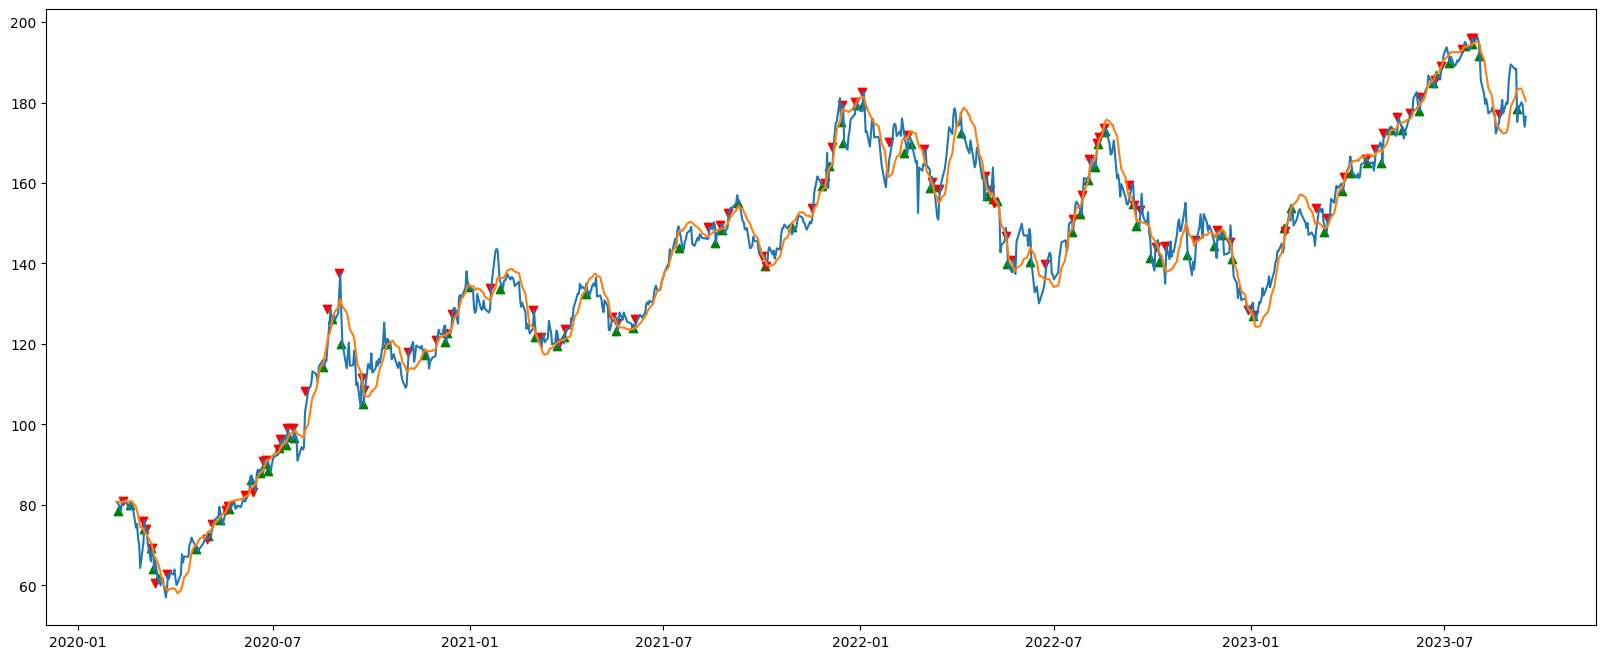

In [25]:
plt.figure(figsize=(20,8))
plt.plot(all_df[['Open','LSMA']])
plt.scatter(buydates, all_df.loc[buydates].shifted_open, marker='^', color='green')
plt.scatter(selldates, all_df.loc[selldates].shifted_open, marker='v', color='red')
# The orange line is the LSMA

In [26]:
(profits > 0).value_counts()

True     64
False    25
dtype: int64

In [29]:
64/(64+25)
# winrate 72%

0.7191011235955056

In [28]:
153.339996/80.362503 - 1

0.9081037831785803